In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import glob
import random


In [2]:
def show_images (images, table_size, fig_size = (10, 10), cmap=None, titles=None):
    """Shows images in table
    Args:
        images (list): list of input images
        table_size (tuple): (cols count, rows count)
        fig_size (tuple): picture (size x, size y) in inches
        cmap (list): list of cmap parameters for each image
        titles (list): list of images titles
    """
    sizex = table_size [0]
    sizey = table_size [1]
    fig, imtable = plt.subplots (sizey, sizex, figsize = fig_size, squeeze=False)
    for j in range (sizey):
        for i in range (sizex):
            im_idx = i + j*sizex
            if (isinstance(cmap, (list, tuple))):
                imtable [j][i].imshow (images[im_idx], cmap=cmap[i])
            else:
                im = images[im_idx]
                if len(im.shape) == 3:
                    imtable [j][i].imshow (im)
                else:
                    imtable [j][i].imshow (im, cmap='gray')
            imtable [j][i].axis('off')
            if not titles is None:
                imtable [j][i].set_title (titles [im_idx], fontsize=32)

    plt.show ()

def plt_show_gray (image):
    """Shows gray image
    Args:
        image: image to show
    """
    plt.figure ()
    plt.imshow (image, cmap='gray')
    plt.show ()

def plt_show (image):
    """Shows color image in RGB format
    Args:
        image: image to show
    """
    plt.figure ()
    plt.imshow (image)
    plt.show ()
    
# Visualizations will be shown in the notebook.
%matplotlib inline

Number of cars: 8792
Number of not cars: 8968


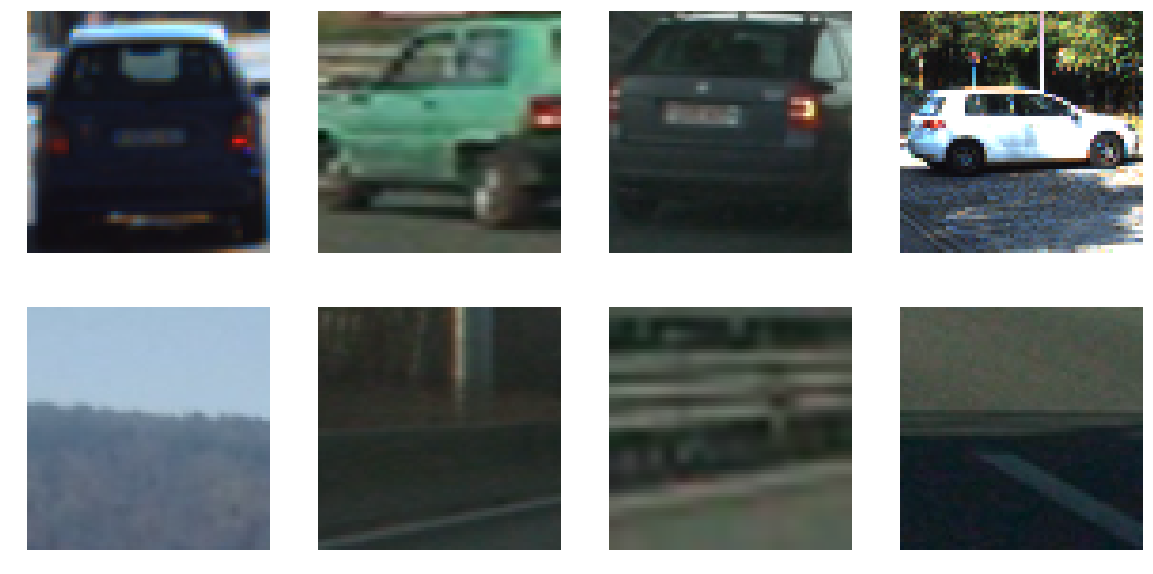

In [3]:
# loading project dataset
# car images and none car images

# get vehicles and non-vehicles images from here
# https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip
# https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip
# and extract into data directory
cars = []
for impath in glob.glob('data/vehicles/**/*.png', recursive=True):
    cars.append (mpimg.imread(impath))

notcars = []
for impath in glob.glob('data/non-vehicles/**/*.png', recursive=True):
    notcars.append (mpimg.imread(impath))

print ('Number of cars:', len(cars))
print ('Number of not cars:', len(notcars))

cars_len = len(cars)
notcars_len = len(notcars)
example_data = [
    cars [random.randint (0, cars_len-1)],
    cars [random.randint (0, cars_len-1)],
    cars [random.randint (0, cars_len-1)],
    cars [random.randint (0, cars_len-1)],
    
    notcars [random.randint (0, notcars_len-1)],
    notcars [random.randint (0, notcars_len-1)],
    notcars [random.randint (0, notcars_len-1)],
    notcars [random.randint (0, notcars_len-1)]
]

show_images (example_data, (4, 2), fig_size=(20, 10))

In [4]:
from skimage.feature import hog
import math

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        feature_image = cv2.cvtColor (img, getattr(cv2, 'COLOR_RGB2' + color_space))
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if color_space == 'GRAY':
            hog_features = get_hog_features(feature_image, orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        elif hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            feature_image = cv2.cvtColor (image, getattr(cv2, 'COLOR_RGB2' + color_space))
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if color_space == 'GRAY':
                hog_features = get_hog_features(feature_image, orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            elif hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
    
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def get_s_from_hls (img):
    hls = cv2.cvtColor (img, cv2.COLOR_BGR2HLS)
    return hls [:,:,2]


In [5]:
# parameters of feature extraction

color_space = 'GRAY' # Can be GRAY, RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 1 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off

//anaconda/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


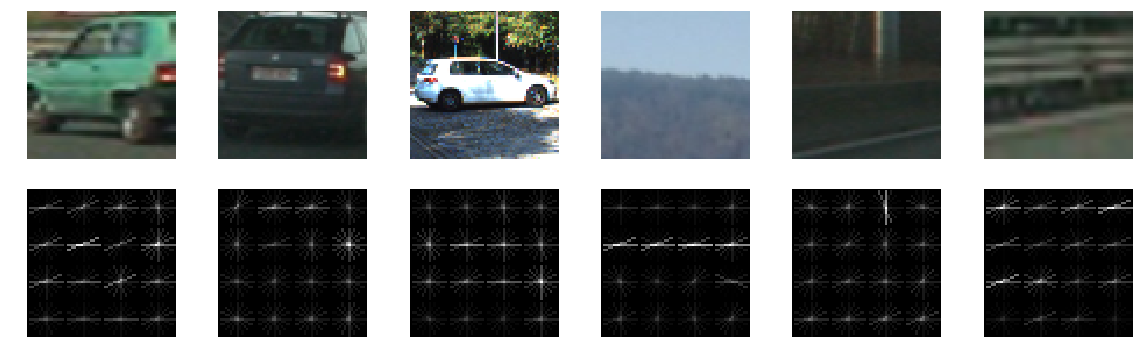

In [6]:
images_for_features = list (example_data [1:-1])

feature_examples = []
feature_examples.extend (images_for_features)

for im in images_for_features:
    features, hog_image = get_hog_features(get_s_from_hls(im), orient, pix_per_cell, cell_per_block, vis=True)
    feature_examples.append (hog_image)
    
show_images(feature_examples, (6, 2), fig_size=(20, 6))

In [7]:
import time
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# combine original and autti datasets and extract features

# original dataset seems to have black cars bias
# so I use only 4000 car images and about 10K car images from autti
all_cars = []
all_cars.extend (cars )
# all_cars.extend (augmented_cars)

# I use bigger number of not car images
all_notcars = []
all_notcars.extend (notcars)
# all_notcars.extend (augmented_notcars)

print ('result dataset:', len(all_cars), 'cars /', len(all_notcars), 'not cars')

ft=time.time()
car_features = extract_features(all_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(all_notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
ft2=time.time()
print ('features extraction time: ', round(ft2-ft, 2))

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))

result dataset: 8792 cars / 8968 not cars


//anaconda/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


features extraction time:  11.75
Feature vector length: 128


In [8]:

svc = SVC ()

svc.fit(X_train, y_train)
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.9865


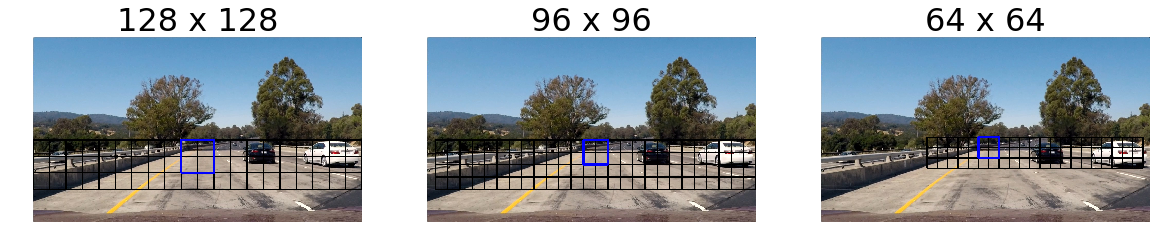

In [19]:
# defining parameters of sliding windows
# I use 3 sliding windows with different sizes, and different positions

image = mpimg.imread('test_images/test1.jpg')
window_img = np.copy(image)

sw_x_limits = [
    [None, None],
    [32, None],
    [412, 1280]
]

sw_y_limits = [
    [400, 640],
    [400, 600],
    [390, 540]
]

sw_window_size = [
    (128, 128),
    (96, 96),
    (80, 80)
]

sw_overlap = [
    (0.5, 0.5),
    (0.5, 0.5),
    (0.5, 0.5)
]

# create sliding windows
windows = slide_window(image, x_start_stop=sw_x_limits[0], y_start_stop=sw_y_limits[0], 
                    xy_window=sw_window_size[0], xy_overlap=sw_overlap[0])

windows2 = slide_window(image, x_start_stop=sw_x_limits[1], y_start_stop=sw_y_limits[1], 
                    xy_window=sw_window_size[1], xy_overlap=sw_overlap[1])

windows3 = slide_window(image, x_start_stop=sw_x_limits[2], y_start_stop=sw_y_limits[2], 
                    xy_window=sw_window_size[2], xy_overlap=sw_overlap[2])

# show sliding windows
sliding_windows = []
sliding_windows.append (draw_boxes(np.copy(image), windows, color=(0, 0, 0), thick=4))
sliding_windows.append (draw_boxes(np.copy(image), windows2, color=(0, 0, 0), thick=4))
sliding_windows.append (draw_boxes(np.copy(image), windows3, color=(0, 0, 0), thick=4))

# drawing one of sliding windows in blue
sliding_windows [0] = draw_boxes (sliding_windows [0], [windows[9]], color=(0, 0, 255), thick=8)
sliding_windows [1] = draw_boxes (sliding_windows [1], [windows2[12]], color=(0, 0, 255), thick=8)
sliding_windows [2] = draw_boxes (sliding_windows [2], [windows3[5]], color=(0, 0, 255), thick=8)

sw_titles = [
    '128 x 128',
    '96 x 96',
    '64 x 64'
]

show_images (sliding_windows, (3, 1), fig_size=(20, 14), titles=sw_titles)

In [10]:
def get_hot_boxes (image):
    dst = np.copy (image)
    all_hot_windows = []
    
    # iterate over previousely defined sliding windows
    for x_limits, y_limits, window_size, overlap in zip (sw_x_limits, sw_y_limits, sw_window_size, sw_overlap):

        windows = slide_window(
            dst,
            x_start_stop=x_limits,
            y_start_stop=y_limits, 
            xy_window=window_size,
            xy_overlap=overlap
        )

        hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
        
        all_hot_windows.extend (hot_windows)

        dst = draw_boxes(dst, hot_windows, color=(0, 0, 1), thick=4)

    return all_hot_windows, dst
        
def get_heat_map(image, bbox_list):
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)

    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap

class AverageHotBox ():
    def __init__ (self, box):
        self.avg_box = [list(p) for p in box]
        self.detected_count = 1
        self.boxes = [box]
    
    def get_strength (self):
        return self.detected_count
    
    def get_box (self):
        if len(self.boxes) > 1:
            center = np.average (np.average (self.boxes, axis=1), axis=0).astype(np.int32).tolist()

            # getting all x and y coordinates of
            # all corners of joined boxes separately
            xs = np.array(self.boxes) [:,:,0]
            ys = np.array(self.boxes) [:,:,1]

            half_width = int(np.std (xs))
            half_height = int(np.std (ys))
            return (
                (
                    center[0] - half_width,
                    center[1] - half_height
                ), (
                    center[0] + half_width,
                    center[1] + half_height
                ))
        else:
            return self.boxes [0]
    
    def is_close (self, box):
        x11 = self.avg_box [0][0]
        y11 = self.avg_box [0][1]
        x12 = self.avg_box [1][0]
        y12 = self.avg_box [1][1]
        x21 = box [0][0]
        y21 = box [0][1]
        x22 = box [1][0]
        y22 = box [1][1]
            
        x_overlap = max(0, min(x12,x22) - max(x11,x21))
        y_overlap = max(0, min(y12,y22) - max(y11,y21))

        area1 = (x12 - x11) * (y12 - y11)
        area2 = (x22 - x21) * (y22 - y21)
        intersection = x_overlap * y_overlap;
        
        if (
            intersection >= 0.3 * area1 or
            intersection >= 0.3 * area2
        ):
            return True
        else:
            return False
    
    def join (self, boxes):
        joined = False
        
        for b in boxes:
            if self.is_close (b):
                boxes.remove (b)
                self.boxes.append (b)
                self.detected_count += 1
                
                self.avg_box [0][0] = min (self.avg_box [0][0], b [0][0])
                self.avg_box [0][1] = min (self.avg_box [0][1], b [0][1])
                self.avg_box [1][0] = max (self.avg_box [1][0], b [1][0])
                self.avg_box [1][1] = max (self.avg_box [1][1], b [1][1])
                
                joined = True

        return joined

def calc_average_boxes (hot_boxes, strength):
    avg_boxes = []
    while len(hot_boxes) > 0:
        b = hot_boxes.pop (0)
        hb = AverageHotBox (b)
        while hb.join (hot_boxes):
            pass
        avg_boxes.append (hb)
    
    boxes = []
    for ab in avg_boxes:
        if ab.get_strength () >= strength:
            boxes.append (ab.get_box ())
    return boxes


In [11]:
def detect_vehicles(image, strength=2, color=(0,0,1), thick=4):
    # hot boxes
    hot_boxes, image_with_hot_boxes = get_hot_boxes (image)
    # average boxes
    avg_boxes = calc_average_boxes (hot_boxes, strength)
    image_with_boxes = draw_boxes(image, avg_boxes, color, thick)
    return image_with_boxes

//anaconda/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


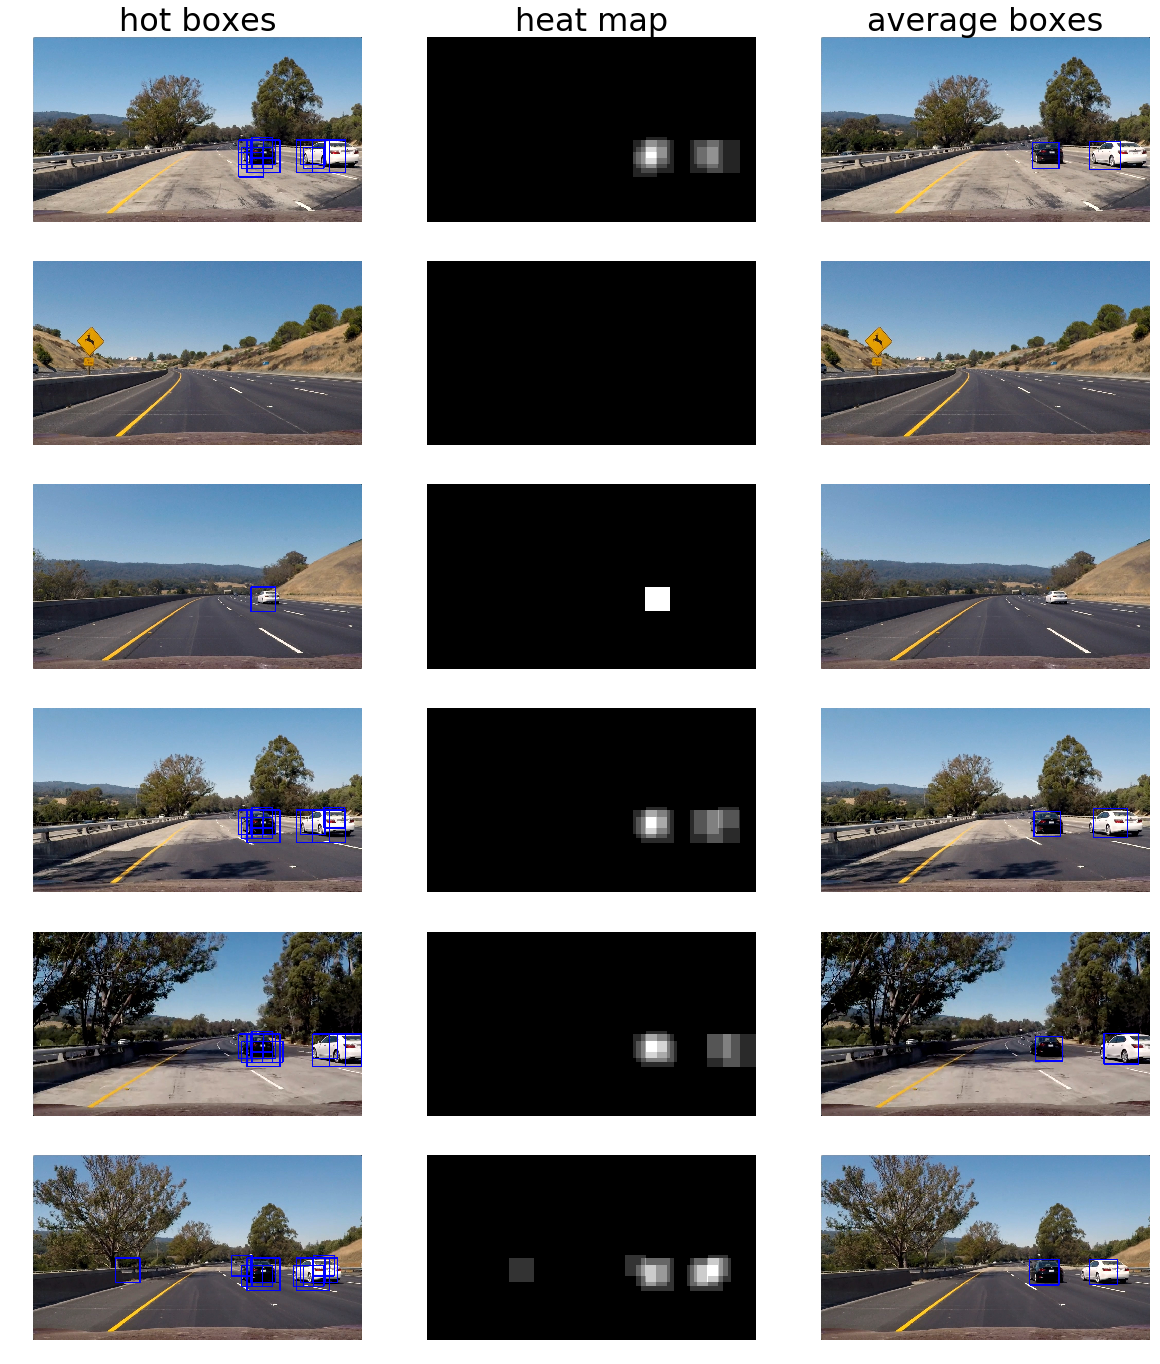

In [12]:
test_images = []
test_images_titles = []

for impath in glob.glob('test_images/test*.jpg'):
    image_orig = mpimg.imread(impath)
    
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image_orig.astype(np.float32)/255

    # hot boxes
    hot_boxes, image_with_hot_boxes = get_hot_boxes (image)
    # heat map
    heat_map = get_heat_map (image, hot_boxes)
    
    # average boxes
    avg_boxes = calc_average_boxes (hot_boxes, 2)
    image_with_boxes = draw_boxes(image, avg_boxes, color=(0, 0, 1), thick=4)
    
    test_images.append (image_with_hot_boxes)
    test_images.append (heat_map)
    test_images.append (image_with_boxes)
    
    test_images_titles.extend (['', '', ''])
    
test_images_titles [0] = 'hot boxes'
test_images_titles [1] = 'heat map'
test_images_titles [2] = 'average boxes'

show_images (test_images, (3, 6), fig_size=(20, 24), titles=test_images_titles)

In [14]:
# in video I use information from multiple frames to
# make average boxes more robust and filter false positives
# I accumulate all hot boxes from last several frames and use them
# for calculating average boxes

class LastHotBoxesQueue ():
    """Class for accumulation of hot boxes from last 10 frames
    """
    def __init__ (self):
        self.queue_max_len = 10 # number items to store
        self.last_boxes = []

    def put_hot_boxes (self, boxes):
        """Put frame hot boxes
        """
        if (len(self.last_boxes) > self.queue_max_len):
            tmp = self.last_boxes.pop (0)
        
        self.last_boxes.append (boxes)
        
    def get_hot_boxes (self):
        """Get last 10 frames hot boxes
        """
        b = []
        for boxes in self.last_boxes:
            b.extend (boxes)
        return b

last_hot_boxes = LastHotBoxesQueue ()

In [15]:
from utils.lane_finder import LaneFinder
from utils.line import *
import pickle
camera_calibration = pickle.load( open( "calibration.p", "rb" ) )
l_line = Line()
r_line = Line()

lane_finder = LaneFinder(l_line, r_line, camera_calibration)

In [18]:
from moviepy.editor import VideoFileClip



def process_image(img_orig):
    image_orig = np.copy(img_orig)
    img_lanes = lane_finder.pipeline(image_orig)
    image = img_lanes.astype(np.float32)/255
    
     # accumulating hot boxes over 10 last frames
    hot_boxes, image_with_hot_boxes = get_hot_boxes (image)
    last_hot_boxes.put_hot_boxes (hot_boxes)
    hot_boxes = last_hot_boxes.get_hot_boxes ()
    
    
    avg_boxes = calc_average_boxes (hot_boxes, 20)
    image_with_boxes = draw_boxes(image, avg_boxes, color=(0, 0, 1), thick=4)
    image_with_vehicles = image_with_boxes * 255
    
    return image_with_vehicles

def process_video (input_path, output_path):
    clip = VideoFileClip (input_path)

    result = clip.fl_image (process_image)
    %time result.write_videofile (output_path, audio=False)

process_video ('project_video.mp4', 'project_video_result.mp4')

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<06:22,  3.29it/s]

  0%|          | 2/1261 [00:00<06:15,  3.35it/s]

  0%|          | 3/1261 [00:00<06:10,  3.39it/s]

  0%|          | 4/1261 [00:01<06:06,  3.43it/s]

  0%|          | 5/1261 [00:01<06:05,  3.43it/s]

  0%|          | 6/1261 [00:01<06:00,  3.48it/s]

  1%|          | 7/1261 [00:02<05:57,  3.51it/s]

  1%|          | 8/1261 [00:02<05:54,  3.53it/s]

  1%|          | 9/1261 [00:02<05:52,  3.55it/s]

  1%|          | 10/1261 [00:02<05:53,  3.54it/s]

  1%|          | 11/1261 [00:03<05:51,  3.55it/s]

  1%|          | 12/1261 [00:03<05:53,  3.53it/s]

  1%|          | 13/1261 [00:03<05:52,  3.54it/s]

  1%|          | 14/1261 [00:03<05:54,  3.52it/s]

  1%|          | 15/1261 [00:04<05:52,  3.54it/s]

  1%|▏         | 16/1261 [00:04<05:50,  3.55it/s]

  1%|▏         | 17/1261 [00:04<05:49,  3.56it/s]

  1%|▏         | 18/1261 [00:05<05:49,  3.56it/s]

  2%|▏         | 19/1261 [00:05<05:53,  3.51it/

 11%|█▏        | 143/1261 [00:41<05:26,  3.43it/s]

 11%|█▏        | 144/1261 [00:41<05:24,  3.44it/s]

 11%|█▏        | 145/1261 [00:42<05:23,  3.45it/s]

 12%|█▏        | 146/1261 [00:42<05:22,  3.45it/s]

 12%|█▏        | 147/1261 [00:42<05:22,  3.45it/s]

 12%|█▏        | 148/1261 [00:43<05:24,  3.43it/s]

 12%|█▏        | 149/1261 [00:43<05:23,  3.44it/s]

 12%|█▏        | 150/1261 [00:43<05:24,  3.43it/s]

 12%|█▏        | 151/1261 [00:43<05:24,  3.42it/s]

 12%|█▏        | 152/1261 [00:44<05:27,  3.38it/s]

 12%|█▏        | 153/1261 [00:44<05:27,  3.38it/s]

 12%|█▏        | 154/1261 [00:44<05:26,  3.39it/s]

 12%|█▏        | 155/1261 [00:45<05:28,  3.37it/s]

 12%|█▏        | 156/1261 [00:45<05:30,  3.34it/s]

 12%|█▏        | 157/1261 [00:45<05:28,  3.36it/s]

 13%|█▎        | 158/1261 [00:46<05:27,  3.37it/s]

 13%|█▎        | 159/1261 [00:46<05:28,  3.36it/s]

 13%|█▎        | 160/1261 [00:46<05:24,  3.39it/s]

 13%|█▎        | 161/1261 [00:46<05:22,  3.41it/s]

 13%|█▎     

 23%|██▎       | 284/1261 [01:24<04:59,  3.26it/s]

 23%|██▎       | 285/1261 [01:24<05:00,  3.25it/s]

 23%|██▎       | 286/1261 [01:24<05:02,  3.22it/s]

 23%|██▎       | 287/1261 [01:24<05:02,  3.22it/s]

 23%|██▎       | 288/1261 [01:25<05:03,  3.21it/s]

 23%|██▎       | 289/1261 [01:25<05:00,  3.23it/s]

 23%|██▎       | 290/1261 [01:25<05:00,  3.23it/s]

 23%|██▎       | 291/1261 [01:26<05:00,  3.23it/s]

 23%|██▎       | 292/1261 [01:26<04:59,  3.23it/s]

 23%|██▎       | 293/1261 [01:26<04:58,  3.25it/s]

 23%|██▎       | 294/1261 [01:27<04:58,  3.24it/s]

 23%|██▎       | 295/1261 [01:27<04:57,  3.24it/s]

 23%|██▎       | 296/1261 [01:27<04:55,  3.26it/s]

 24%|██▎       | 297/1261 [01:28<04:52,  3.30it/s]

 24%|██▎       | 298/1261 [01:28<04:51,  3.31it/s]

 24%|██▎       | 299/1261 [01:28<04:50,  3.32it/s]

 24%|██▍       | 300/1261 [01:28<04:48,  3.33it/s]

 24%|██▍       | 301/1261 [01:29<04:48,  3.33it/s]

 24%|██▍       | 302/1261 [01:29<04:50,  3.30it/s]

 24%|██▍    

 34%|███▎      | 425/1261 [02:09<05:06,  2.73it/s]

 34%|███▍      | 426/1261 [02:09<05:26,  2.56it/s]

 34%|███▍      | 427/1261 [02:10<05:39,  2.46it/s]

 34%|███▍      | 428/1261 [02:10<05:47,  2.40it/s]

 34%|███▍      | 429/1261 [02:11<05:54,  2.35it/s]

 34%|███▍      | 430/1261 [02:11<05:51,  2.36it/s]

 34%|███▍      | 431/1261 [02:12<05:45,  2.40it/s]

 34%|███▍      | 432/1261 [02:12<05:32,  2.50it/s]

 34%|███▍      | 433/1261 [02:12<05:16,  2.61it/s]

 34%|███▍      | 434/1261 [02:13<05:08,  2.68it/s]

 34%|███▍      | 435/1261 [02:13<05:01,  2.74it/s]

 35%|███▍      | 436/1261 [02:13<04:59,  2.75it/s]

 35%|███▍      | 437/1261 [02:14<04:52,  2.82it/s]

 35%|███▍      | 438/1261 [02:14<04:47,  2.86it/s]

 35%|███▍      | 439/1261 [02:14<04:44,  2.89it/s]

 35%|███▍      | 440/1261 [02:15<04:39,  2.93it/s]

 35%|███▍      | 441/1261 [02:15<04:34,  2.99it/s]

 35%|███▌      | 442/1261 [02:15<04:34,  2.99it/s]

 35%|███▌      | 443/1261 [02:16<04:31,  3.01it/s]

 35%|███▌   

 45%|████▍     | 566/1261 [02:57<03:59,  2.90it/s]

 45%|████▍     | 567/1261 [02:57<03:59,  2.89it/s]

 45%|████▌     | 568/1261 [02:58<04:09,  2.78it/s]

 45%|████▌     | 569/1261 [02:58<04:11,  2.75it/s]

 45%|████▌     | 570/1261 [02:58<04:09,  2.77it/s]

 45%|████▌     | 571/1261 [02:59<04:05,  2.81it/s]

 45%|████▌     | 572/1261 [02:59<03:59,  2.88it/s]

 45%|████▌     | 573/1261 [02:59<03:55,  2.92it/s]

 46%|████▌     | 574/1261 [03:00<03:51,  2.97it/s]

 46%|████▌     | 575/1261 [03:00<03:49,  2.99it/s]

 46%|████▌     | 576/1261 [03:00<03:47,  3.01it/s]

 46%|████▌     | 577/1261 [03:01<03:45,  3.03it/s]

 46%|████▌     | 578/1261 [03:01<03:44,  3.04it/s]

 46%|████▌     | 579/1261 [03:01<03:45,  3.02it/s]

 46%|████▌     | 580/1261 [03:02<03:52,  2.93it/s]

 46%|████▌     | 581/1261 [03:02<03:48,  2.97it/s]

 46%|████▌     | 582/1261 [03:02<03:45,  3.02it/s]

 46%|████▌     | 583/1261 [03:03<03:44,  3.02it/s]

 46%|████▋     | 584/1261 [03:03<03:44,  3.01it/s]

 46%|████▋  

 56%|█████▌    | 707/1261 [03:46<04:06,  2.24it/s]

 56%|█████▌    | 708/1261 [03:46<04:09,  2.22it/s]

 56%|█████▌    | 709/1261 [03:47<04:07,  2.23it/s]

 56%|█████▋    | 710/1261 [03:47<04:07,  2.23it/s]

 56%|█████▋    | 711/1261 [03:47<04:04,  2.25it/s]

 56%|█████▋    | 712/1261 [03:48<03:54,  2.34it/s]

 57%|█████▋    | 713/1261 [03:48<03:44,  2.44it/s]

 57%|█████▋    | 714/1261 [03:49<03:42,  2.46it/s]

 57%|█████▋    | 715/1261 [03:49<03:35,  2.53it/s]

 57%|█████▋    | 716/1261 [03:49<03:30,  2.59it/s]

 57%|█████▋    | 717/1261 [03:50<03:25,  2.65it/s]

 57%|█████▋    | 718/1261 [03:50<03:20,  2.71it/s]

 57%|█████▋    | 719/1261 [03:50<03:19,  2.71it/s]

 57%|█████▋    | 720/1261 [03:51<03:18,  2.73it/s]

 57%|█████▋    | 721/1261 [03:51<03:22,  2.67it/s]

 57%|█████▋    | 722/1261 [03:52<03:17,  2.73it/s]

 57%|█████▋    | 723/1261 [03:52<03:20,  2.68it/s]

 57%|█████▋    | 724/1261 [03:52<03:16,  2.73it/s]

 57%|█████▋    | 725/1261 [03:53<03:10,  2.81it/s]

 58%|█████▊ 

 67%|██████▋   | 848/1261 [04:37<02:25,  2.85it/s]

 67%|██████▋   | 849/1261 [04:37<02:25,  2.83it/s]

 67%|██████▋   | 850/1261 [04:37<02:23,  2.85it/s]

 67%|██████▋   | 851/1261 [04:38<02:24,  2.84it/s]

 68%|██████▊   | 852/1261 [04:38<02:22,  2.87it/s]

 68%|██████▊   | 853/1261 [04:38<02:21,  2.89it/s]

 68%|██████▊   | 854/1261 [04:39<02:20,  2.89it/s]

 68%|██████▊   | 855/1261 [04:39<02:20,  2.89it/s]

 68%|██████▊   | 856/1261 [04:39<02:22,  2.84it/s]

 68%|██████▊   | 857/1261 [04:40<02:20,  2.87it/s]

 68%|██████▊   | 858/1261 [04:40<02:20,  2.86it/s]

 68%|██████▊   | 859/1261 [04:40<02:20,  2.85it/s]

 68%|██████▊   | 860/1261 [04:41<02:20,  2.86it/s]

 68%|██████▊   | 861/1261 [04:41<02:19,  2.88it/s]

 68%|██████▊   | 862/1261 [04:41<02:18,  2.88it/s]

 68%|██████▊   | 863/1261 [04:42<02:16,  2.93it/s]

 69%|██████▊   | 864/1261 [04:42<02:14,  2.96it/s]

 69%|██████▊   | 865/1261 [04:42<02:13,  2.96it/s]

 69%|██████▊   | 866/1261 [04:43<02:12,  2.98it/s]

 69%|██████▉

 78%|███████▊  | 989/1261 [05:26<01:33,  2.90it/s]

 79%|███████▊  | 990/1261 [05:27<01:32,  2.92it/s]

 79%|███████▊  | 991/1261 [05:27<01:34,  2.84it/s]

 79%|███████▊  | 992/1261 [05:27<01:36,  2.78it/s]

 79%|███████▊  | 993/1261 [05:28<01:38,  2.72it/s]

 79%|███████▉  | 994/1261 [05:28<01:37,  2.73it/s]

 79%|███████▉  | 995/1261 [05:28<01:36,  2.76it/s]

 79%|███████▉  | 996/1261 [05:29<01:35,  2.77it/s]

 79%|███████▉  | 997/1261 [05:29<01:38,  2.68it/s]

 79%|███████▉  | 998/1261 [05:30<01:39,  2.65it/s]

 79%|███████▉  | 999/1261 [05:30<01:40,  2.60it/s]

 79%|███████▉  | 1000/1261 [05:30<01:42,  2.56it/s]

 79%|███████▉  | 1001/1261 [05:31<01:41,  2.57it/s]

 79%|███████▉  | 1002/1261 [05:31<01:43,  2.51it/s]

 80%|███████▉  | 1003/1261 [05:32<01:45,  2.46it/s]

 80%|███████▉  | 1004/1261 [05:32<01:46,  2.41it/s]

 80%|███████▉  | 1005/1261 [05:32<01:48,  2.37it/s]

 80%|███████▉  | 1006/1261 [05:33<01:47,  2.37it/s]

 80%|███████▉  | 1007/1261 [05:33<01:50,  2.30it/s]

 80%

 89%|████████▉ | 1128/1261 [06:23<00:54,  2.43it/s]

 90%|████████▉ | 1129/1261 [06:23<00:53,  2.47it/s]

 90%|████████▉ | 1130/1261 [06:23<00:52,  2.51it/s]

 90%|████████▉ | 1131/1261 [06:24<00:51,  2.54it/s]

 90%|████████▉ | 1132/1261 [06:24<00:50,  2.56it/s]

 90%|████████▉ | 1133/1261 [06:25<00:49,  2.58it/s]

 90%|████████▉ | 1134/1261 [06:25<00:48,  2.59it/s]

 90%|█████████ | 1135/1261 [06:25<00:48,  2.59it/s]

 90%|█████████ | 1136/1261 [06:26<00:48,  2.60it/s]

 90%|█████████ | 1137/1261 [06:26<00:47,  2.60it/s]

 90%|█████████ | 1138/1261 [06:26<00:47,  2.59it/s]

 90%|█████████ | 1139/1261 [06:27<00:47,  2.59it/s]

 90%|█████████ | 1140/1261 [06:27<00:47,  2.56it/s]

 90%|█████████ | 1141/1261 [06:28<00:47,  2.54it/s]

 91%|█████████ | 1142/1261 [06:28<00:46,  2.54it/s]

 91%|█████████ | 1143/1261 [06:28<00:46,  2.55it/s]

 91%|█████████ | 1144/1261 [06:29<00:45,  2.55it/s]

 91%|█████████ | 1145/1261 [06:29<00:45,  2.56it/s]

 91%|█████████ | 1146/1261 [06:30<00:44,  2.56

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

CPU times: user 20min 45s, sys: 1min 18s, total: 22min 4s
Wall time: 7min 16s
